In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
working_dir ='~/Project/pred-future-sales'
sales_train_file = pd.read_csv(working_dir + '/data/raw/sales_train.csv')
test_file = pd.read_csv(working_dir + '/data/raw/test.csv')
shops_file = pd.read_csv(working_dir + '/data/raw/shops.csv')
items = pd.read_csv(working_dir + '/data/raw/items.csv')
item_categories = pd.read_csv(working_dir + '/data/raw/item_categories.csv')
# sample_submission = pd.read_csv(working_dir + '/data/raw/sample_submission.csv')

In [3]:
sales_train_file.head(10)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
5,10.01.2013,0,25,2564,349.00,1.0
6,02.01.2013,0,25,2565,549.00,1.0
7,04.01.2013,0,25,2572,239.00,1.0
8,11.01.2013,0,25,2572,299.00,1.0
9,03.01.2013,0,25,2573,299.00,3.0


In [4]:
sales_train_file = sales_train_file.astype({'date': 'datetime64', 'date_block_num': 'int64', 'shop_id': 'int64', 
                         'item_id': 'int64', 'item_price': 'float64', 'item_cnt_day': 'float64'})

In [5]:
test_file.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [6]:
sales_train_file.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


In [7]:
print('Number of row in test_file: {}'.format(test_file['ID'].nunique()))
print('Number of unique shops in test_file: {}'.format(test_file['shop_id'].nunique()))
print('Number of unique items in test_file: {}'.format(test_file['item_id'].nunique()))

Number of row in test_file: 214200
Number of unique shops in test_file: 42
Number of unique items in test_file: 5100


In [8]:
print('Number of unique shops in shop_file: {}'.format(shops_file['shop_id'].nunique()))
print('Number of unique items in item_file: {}'.format(items['item_id'].nunique()))
print('Number of unique item_category in item_category_file: {}'.format(item_categories['item_category_id'].nunique()))

Number of unique shops in shop_file: 60
Number of unique items in item_file: 22170
Number of unique item_category in item_category_file: 84


In [9]:
print('Number of unique shops sold within 35 month in sales_train_file: {}'.format(sales_train_file['shop_id'].nunique()))
print('Number of unique items sold within 35 month in sales_train_file: {}'.format(sales_train_file['item_id'].nunique()))

Number of unique shops sold within 35 month in sales_train_file: 60
Number of unique items sold within 35 month in sales_train_file: 21807


In [10]:
common_items = set(test_file['item_id'].values) & set(sales_train_file['item_id'])
common_shops = set(test_file['shop_id'].values) & set(sales_train_file['shop_id'])
new_items = set(test_file['item_id']).difference(common_items)
new_shops = set(test_file['shop_id']).difference(common_shops)
print('Number of new items in test_file: {}'.format(len(new_items)))
print('Number of new shops in test_file: {}'.format(len(new_shops)))

Number of new items in test_file: 363
Number of new shops in test_file: 0


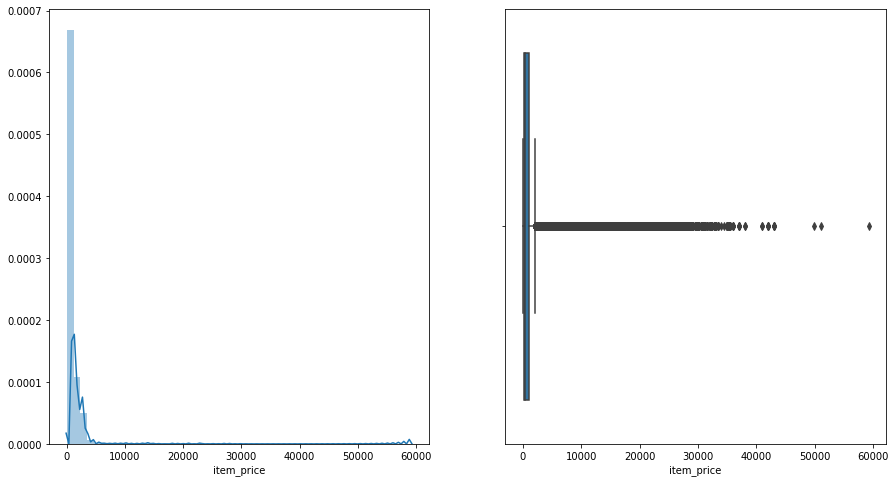

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(15, 8))
sns.distplot(sales_train_file.item_price[sales_train_file.item_price <= 100000], ax=axs[0])
sns.boxplot(sales_train_file.item_price[sales_train_file.item_price <= 100000], ax=axs[1])

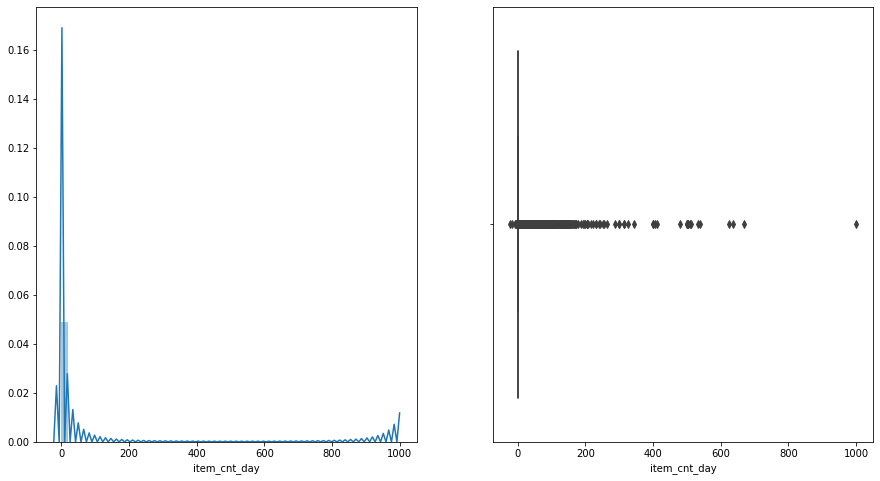

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(15, 8))
sns.distplot(sales_train_file.item_cnt_day[sales_train_file.item_cnt_day <= 1000], ax=axs[0])
sns.boxplot(sales_train_file.item_cnt_day[sales_train_file.item_cnt_day <= 1000], ax=axs[1])

In [13]:
sales_train_file[sales_train_file.item_price < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,2013-05-15,4,32,2973,-1.0,1.0


Removed rows whose "item_price"s are more than 100000 and "item_cnt_day"s are more than 1000.
Replaced a value which is item_price with -1 to median of item_price.

In [14]:
sales_train_file = sales_train_file[(sales_train_file.item_price <= 100000) & (sales_train_file.item_cnt_day <= 1000)]
sales_train_file.loc[sales_train_file.item_price < 0, 'item_price'] = np.median(sales_train_file.item_price.values)

Generated columns for "year", "month", "day", "dayofweek"

In [15]:
new_cols = ['year', 'month', 'day', 'dayofweek']
for c in new_cols:
    sales_train_file[c] = getattr(sales_train_file.date.dt, c)

In [16]:
sales_train_file.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month,day,dayofweek
0,2013-02-01,0,59,22154,999.00,1.0,2013,2,1,4
1,2013-03-01,0,25,2552,899.00,1.0,2013,3,1,4
2,2013-05-01,0,25,2552,899.00,-1.0,2013,5,1,2
3,2013-06-01,0,25,2554,1709.05,1.0,2013,6,1,5
4,2013-01-15,0,25,2555,1099.00,1.0,2013,1,15,1


Created dataframe grouped by item_id, shop_id, and date_block_num

In [17]:
shop_item_date_block = sales_train_file.groupby(['date_block_num', 'shop_id', 'item_id'])['item_price', 'item_cnt_day'].sum().reset_index()
shop_item_date_block = shop_item_date_block.rename(columns={'item_price': 'item_total_price', 
                                     'item_cnt_day': 'item_cnt_month'})

In [18]:
shop_item_date_block.head()

,date_block_num,shop_id,item_id,item_total_price,item_cnt_month
0,0,0,32,884.0,6.0
1,0,0,33,1041.0,3.0
2,0,0,35,247.0,1.0
3,0,0,43,221.0,1.0
4,0,0,51,257.0,2.0


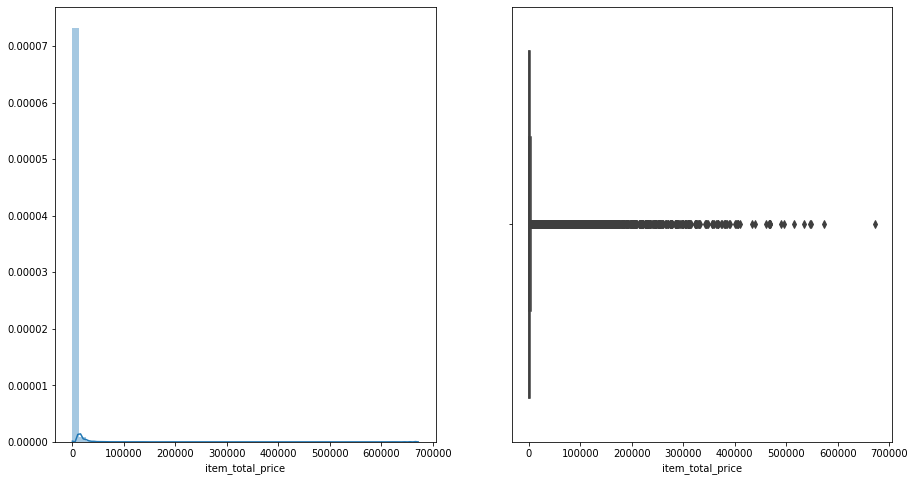

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(15, 8))
sns.distplot(shop_item_date_block.item_total_price, ax=axs[0])
sns.boxplot(shop_item_date_block.item_total_price, ax=axs[1])

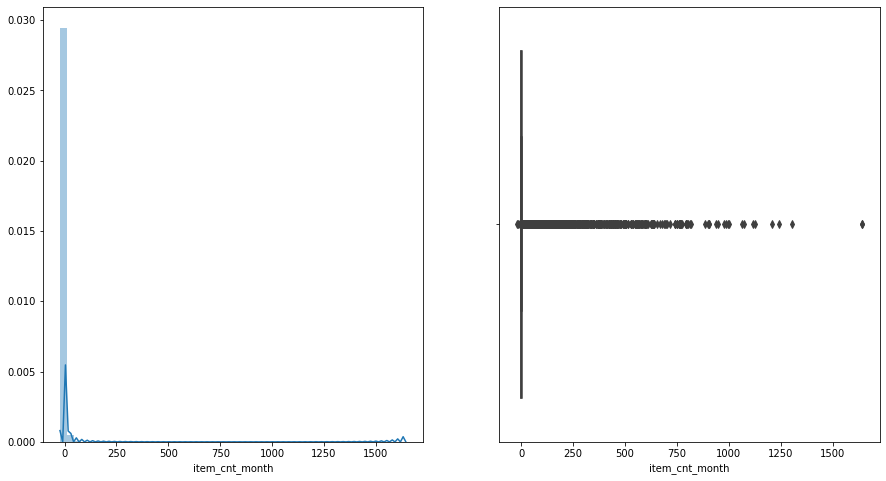

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(15, 8))
sns.distplot(shop_item_date_block.item_cnt_month, ax=axs[0])
sns.boxplot(shop_item_date_block.item_cnt_month, ax=axs[1])

Check shop and item 

In [21]:
shops_file.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [22]:
print("Number of unique shops: {}".format(shops_file.shop_id.nunique()))
print("Number of unique shop-name: {}".format(shops_file.shop_name.nunique()))

Number of unique shops: 60
Number of unique shop-name: 60


In [23]:
shops_file.loc[shops_file.shop_id == 59]

,shop_name,shop_id
59,"Ярославль ТЦ ""Альтаир""",59


In [24]:
from sklearn.preprocessing import LabelEncoder

In [25]:
shops_file.loc[shops_file.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops_file['city'] = shops_file['shop_name'].str.split().map(lambda x: x[0])
shops_file.loc[shops_file.city == '!Якутск', 'city'] = 'Якутск'
shops_file['city_code'] = LabelEncoder().fit_transform(shops_file['city'])

In [26]:
shops_file.head()

,shop_name,shop_id,city,city_code
0,"!Якутск Орджоникидзе, 56 фран",0,Якутск,29
1,"!Якутск ТЦ ""Центральный"" фран",1,Якутск,29
2,"Адыгея ТЦ ""Мега""",2,Адыгея,0
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,1
4,"Волжский ТЦ ""Волга Молл""",4,Волжский,2


In [27]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [28]:
split_temp = item_categories['item_category_name'].str.split(' - ')
item_categories['type'] = split_temp.map(lambda x: x[0])
item_categories['subtype'] = split_temp.map(lambda x: x[1] if len(x) > 1 else x[0])
item_categories['type_code'] = LabelEncoder().fit_transform(item_categories['type'])
item_categories['subtype_code'] = LabelEncoder().fit_transform(item_categories['subtype'])

In [29]:
item_categories.head()

,item_category_name,item_category_id,type,subtype,type_code,subtype_code
0,PC - Гарнитуры/Наушники,0,PC,Гарнитуры/Наушники,0,31
1,Аксессуары - PS2,1,Аксессуары,PS2,1,11
2,Аксессуары - PS3,2,Аксессуары,PS3,1,12
3,Аксессуары - PS4,3,Аксессуары,PS4,1,13
4,Аксессуары - PSP,4,Аксессуары,PSP,1,15


In [30]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


Create training dataset similar to test dataset.
Create all pair of shops and items occurred in the month.

In [32]:
sales_train_file.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month,day,dayofweek
0,2013-02-01,0,59,22154,999.00,1.0,2013,2,1,4
1,2013-03-01,0,25,2552,899.00,1.0,2013,3,1,4
2,2013-05-01,0,25,2552,899.00,-1.0,2013,5,1,2
3,2013-06-01,0,25,2554,1709.05,1.0,2013,6,1,5
4,2013-01-15,0,25,2555,1099.00,1.0,2013,1,15,1


In [35]:
from itertools import product

In [37]:
matrix = []
cols = ['date_block_num', 'shop_id', 'item_id']
for i in range(34):
    window = sales_train_file[sales_train_file['date_block_num'] == i]
    matrix.append(np.array(list(product([i], window['shop_id'].unique(), window['item_id'].unique())), dtype='int32'))
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix.astype(dtype={'date_block_num': 'int32', 'shop_id': 'int32', 'item_id': 'int32'})
matrix.sort_values(cols, inplace=True)

In [49]:
matrix.head()

,date_block_num,shop_id,item_id
139255,0,0,19
141495,0,0,27
144968,0,0,28
142661,0,0,29
138947,0,0,32


In [39]:
shop_item_date_block.head()

,date_block_num,shop_id,item_id,item_total_price,item_cnt_month
0,0,0,32,884.0,6.0
1,0,0,33,1041.0,3.0
2,0,0,35,247.0,1.0
3,0,0,43,221.0,1.0
4,0,0,51,257.0,2.0


In [50]:
matrix = pd.merge(matrix, shop_item_date_block, on=cols, how='left')

In [51]:
matrix.head()

,date_block_num,shop_id,item_id,item_total_price,item_cnt_month
0,0,0,19,NaN,NaN
1,0,0,27,NaN,NaN
2,0,0,28,NaN,NaN
3,0,0,29,NaN,NaN
4,0,0,32,884.0,6.0


In [60]:
matrix['item_total_price'] = matrix['item_total_price']\
                                .fillna(0)\
                                .astype(np.float64)

In [61]:
matrix['item_cnt_month'] = matrix['item_cnt_month']\
                                .fillna(0)\
                                .clip(0, 20)\
                                .astype(np.float64)\

In [63]:
matrix.head()

,date_block_num,shop_id,item_id,item_total_price,item_cnt_month
0,0,0,19,0.0,0.0
1,0,0,27,0.0,0.0
2,0,0,28,0.0,0.0
3,0,0,29,0.0,0.0
4,0,0,32,884.0,6.0


Crate Test file

In [64]:
test_file.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [66]:
test_file['date_block_num'] = 34
test_file['date_block_num'] = test_file['date_block_num'].astype(np.int32)
test_file['shop_id'] = test_file['shop_id'].astype(np.int32)
test_file['item_id'] = test_file['item_id'].astype(np.int32)

Concatenate matrix, shop, item information

In [67]:
matrix = pd.merge(matrix, shops_file, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, item_categories, on=['item_category_id'], how='left')

In [69]:
matrix.head()

,date_block_num,shop_id,item_id,item_total_price,item_cnt_month,shop_name,city,city_code,item_name,item_category_id,item_category_name,type,subtype,type_code,subtype_code
0,0,0,19,0.0,0.0,"!Якутск Орджоникидзе, 56 фран",Якутск,29,/ЗОЛОТАЯ КОЛЛЕКЦИЯ м/ф-72,40,Кино - DVD,Кино,DVD,11,6
1,0,0,27,0.0,0.0,"!Якутск Орджоникидзе, 56 фран",Якутск,29,"007 Legends [PS3, русская версия]",19,Игры - PS3,Игры,PS3,5,12
2,0,0,28,0.0,0.0,"!Якутск Орджоникидзе, 56 фран",Якутск,29,"007 Legends [PС, Jewel, русская версия]",30,Игры PC - Стандартные издания,Игры PC,Стандартные издания,8,57
3,0,0,29,0.0,0.0,"!Якутск Орджоникидзе, 56 фран",Якутск,29,"007 Legends [Xbox 360, русская версия]",23,Игры - XBOX 360,Игры,XBOX 360,5,18
4,0,0,32,884.0,6.0,"!Якутск Орджоникидзе, 56 фран",Якутск,29,1+1,40,Кино - DVD,Кино,DVD,11,6


In [70]:
matrix['city_code'] = matrix['city_code'].astype(np.int32)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int32)
matrix['type_code'] = matrix['type_code'].astype(np.int32)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int32)

Target lags feature